# **Librerias**

In [1]:
# Importamos las Librerias 

import sklearn 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Versiones 

print(f'Numpy Version: {np.__version__}')
print(f'Scikit-Learn Version: {sklearn.__version__}') 
print(f'Matplotlib Version: {matplotlib.__version__}')

Numpy Version: 2.3.1
Scikit-Learn Version: 1.7.1
Matplotlib Version: 3.10.3


# **Discriminantes Gaussianos (GDA)**  

Los **Discriminantes Gaussianos** son **clasificadores generativos** en los que:

La **probabilidad** de que una **muestra** $x$ pertenezca a una **clase** $c$ se modela como la **probabilidad** de que $x$ provenga de una **distribucion normal multivariante** especifica de esa **clase** $c$

$$p(x \mid y = c, \theta) = \mathcal{N}(x \mid \mu_c, \Sigma_c)$$

**Donde:**

* $\mu_c$ el vector de medias (centroide) de la clase $c$

* $\Sigma_c$ la matriz de covarianza de la clase $c$

Podemos **clasificar** una nueva **muestra** $x$ se utilizando la **regla de Bayes**, que selecciona la clase con **mayor probabilidad posterior**:

$$\hat y(x) = \argmax_{c} \hspace{0.2cm} p(y = c \mid x, \theta_c)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \frac{p(y = c \mid \pi) \cdot p(x \mid y = c, \theta_c)}{\sum_c \hspace{0.1cm} p(y = c \mid \pi) \cdot p(x \mid y = c, \theta_c)}$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log p(y = c \mid \pi) + \log p(x \mid y = c, \theta_c)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log p(y = c \mid \pi) + \log \mathcal{N}(x \mid \mu_c, \Sigma_c)$$

Eliminamos el denominador ya que es el mismo para todas las clases y se convierte en un termino constante

**Donde:**

* $p(y = c \mid x, \theta_c)$ posterior (probabilidad posterior)

* $\log p(y = c \mid \pi)$ prior (distribución a priori)

* $\log p(x \mid y = c, \theta_c)$ likelihood (verosimilitud)

**Nota:** Si se asume que las matrices $\Sigma_c$ son diagonales y que las variables son condicionalmente independientes dado la clase, entonces el modelo es equivalente a Naive Bayes con distribuciones gaussianas univariantes para cada variable.

# **Quadratic Discriminat Analysis (QDA)**

En **QDA** cada **clase** $c$ puede tener su propia **matriz de covarianza** $\Sigma_c$, lo que da lugar a **fronteras de decisión cuadráticas** en el espacio de entrada.

### **Con Priors**

Cuando se **conocen** o **se estiman** las probabilidades a **priori** $p(y = c \mid \pi)$, la regla de decisión óptima es:

$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log p(y = c \mid \pi) + \log \mathcal{N}(x \mid \mu_c, \Sigma_c)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log p(y = c \mid \pi) + \log \left(\frac{1}{(2 \pi)^{\frac{D}{2}} \cdot |\Sigma_c|^{\frac{1}{2}}} \cdot e^{-\frac{1}{2} (x - \mu_c)^T \Sigma_c^{-1} (x - \mu_c)}\right)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left(\log p(y = c \mid \pi) - \frac{D}{2} \log(2 \pi) - \frac{1}{2} \log(|\Sigma_c|) - \frac{1}{2} (x - \mu_c)^T \Sigma_c^{-1} (x - \mu_c)\right)$$

$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left[\log p(y = c \mid \pi) - \frac{1}{2} \log(|\Sigma_c|) - \frac{1}{2} (x - \mu_c)^T \Sigma_c^{-1} (x - \mu_c)\right]$$

**Nota:** Se omiten los términos constantes respecto a $c$ en la función de decisión, ya que no afectan el resultado del operador $\argmax$

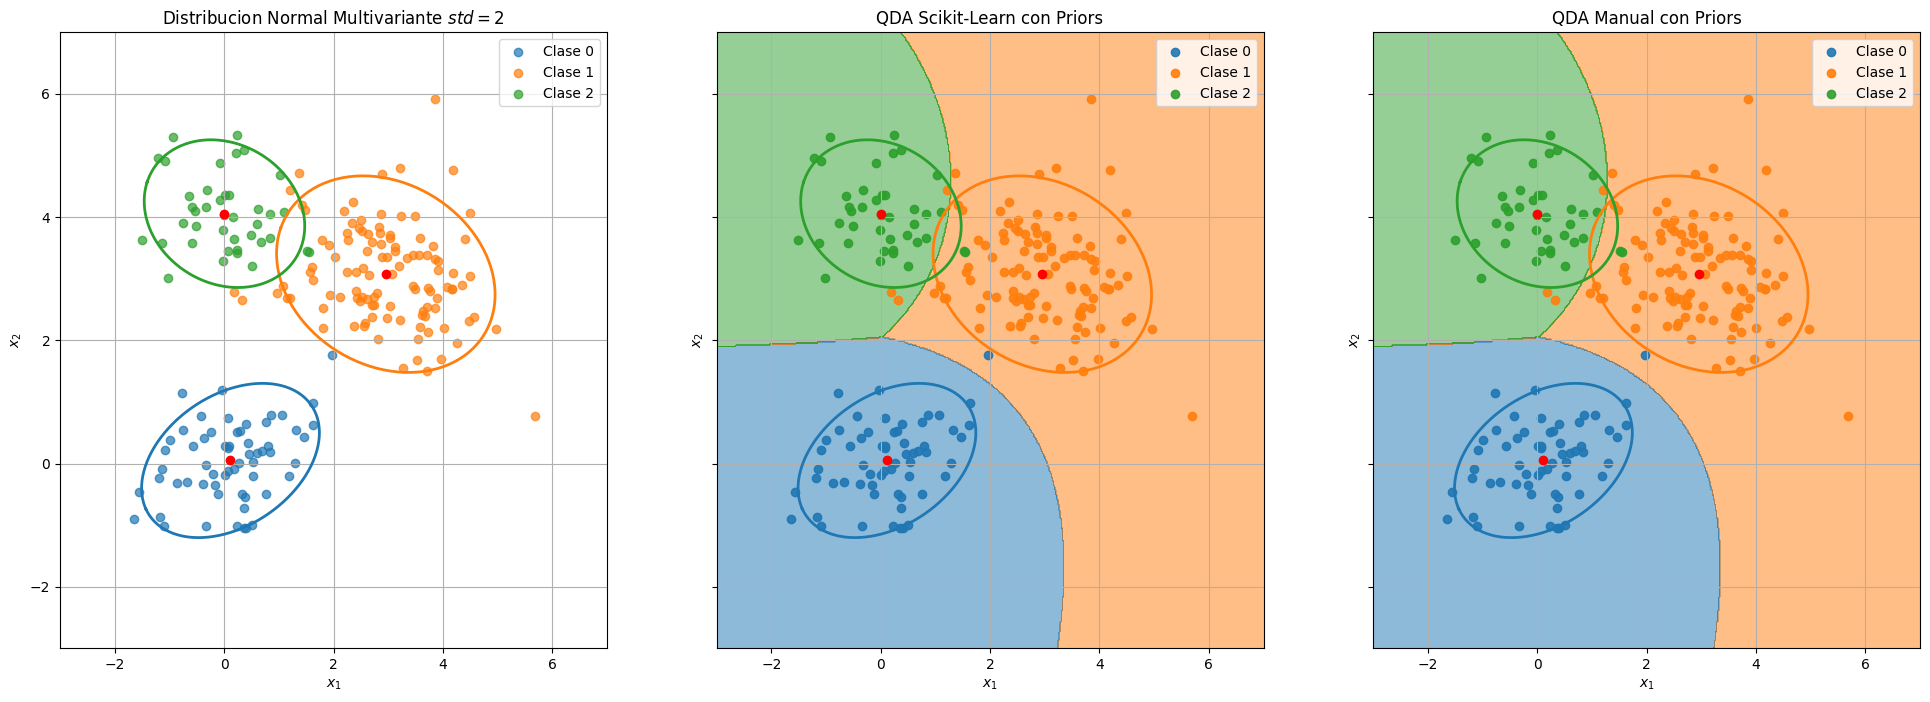

In [2]:
# Generamos los datos siguiendo una distribuccion normal multivariante

np.random.seed(42)

n_samples = [60, 110, 40] 

means = [[0, 0], [3, 3], [0, 4]]
covariances = [[[0.8, 0.3], [0.3, 0.5]], [[1.0, -0.2], [-0.2, 0.7]], [[0.5, 0.0], [0.0, 0.5]]]

def generate_data(means, covariances, n_samples):

    features = []
    labels = []

    for idx in range(0, len(means)):
        x = np.random.multivariate_normal(mean = means[idx], cov = covariances[idx], size = n_samples[idx])

        features.append(x)
        labels.append(np.full(shape = n_samples[idx], fill_value = idx))

    features = np.vstack(features)
    labels = np.concatenate(labels)

    return features, labels

features, labels = generate_data(means, covariances, n_samples)

# Calculamos la Distribucion Prior de las Clases 

priors = np.array(n_samples) / np.sum(n_samples)

# Estimamos la Media y la Matriz de Covarianza Proveniente de los Datos Generados (Para cada clase por separado)

estimated_means = []
estimated_covs = []

for c in range(len(means)):
    X_c = features[labels == c]

    mean = np.mean(X_c, axis = 0)
    cov = np.cov(X_c, rowvar = False)

    estimated_means.append(mean)
    estimated_covs.append(cov)

# Ajustamos el Discriminador Cuadratico de Sckit-Learn

qda = QuadraticDiscriminantAnalysis(priors = priors, reg_param = 0.0)

qda.fit(features, labels)

# Ajustamos el Discriminador Cuadratico Manual 

def discriminant(grid, priors, means, covariances): 

    n = grid.shape[0] 
    D = grid.shape[1]

    predictions = np.zeros(shape = (n, len(means)))

    for classe in range(0, len(means)): 

        mean = means[classe] 
        cov = covariances[classe]  
        prior = priors[classe]       

        cov_sign, cov_log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)

        diff = grid - mean
        pred = np.log(prior) - ((1/2) * cov_log_det) - ((1/2) * np.einsum('ij,jk,ik->i', diff, cov_inv, diff))

        predictions[:, classe] = pred 

    predictions = np.argmax(predictions, axis = 1) 

    return predictions

# Definimos una Malla para Inferir todos los Puntos de ese espacio

x_vals = np.linspace(-3, 7, 500) 
y_vals = np.linspace(-3, 7, 500)

X, Y = np.meshgrid(x_vals, y_vals)

grid = np.c_[X.ravel(), Y.ravel()]

# Inferimos sobre la Malla con el Discriminador previamente ajustado

predict_auto = qda.predict(grid)
predict_auto = predict_auto.reshape(X.shape) 

predict_manual = discriminant(grid, priors, estimated_means, estimated_covs)
predict_manual = predict_manual.reshape(X.shape) 

# Visualizamos

def plot_cov_ellipse(cov, mean, ax, std, color, **kwargs):
   
    eigvals, eigvecs = np.linalg.eigh(cov)

    order = eigvals.argsort()[::-1]

    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    theta = np.linspace(0, 2*np.pi, 200)
    circle = np.array([np.cos(theta), np.sin(theta)])

    scale = std * np.sqrt(eigvals)

    transform = eigvecs @ np.diag(scale)
    ellipse = transform @ circle + mean.reshape(2, 1)

    ax.plot(ellipse[0], ellipse[1], color = color, linewidth = 2)

colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 8), sharex = True, sharey = True)

for class_id in range(0, len(means)):
    X_class = features[labels == class_id]
    
    ax[0].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.7, color = colors[class_id])
    
    mean = np.mean(X_class, axis = 0)
    ax[0].plot(mean[0], mean[1], 'ro')
    
    cov = np.cov(X_class.T)
    plot_cov_ellipse(cov, mean, ax[0], std = 2, color = colors[class_id])

ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title(f"Distribucion Normal Multivariante $std = 2$")
ax[0].legend()
ax[0].grid(True)

ax[1].contourf(X, Y, predict_auto, alpha = 0.5, cmap = ListedColormap(colors))
ax[2].contourf(X, Y, predict_manual, alpha = 0.5, cmap = ListedColormap(colors))

for idx in range(1, 3):
    for class_id in range(0, len(means)):
        X_class = features[labels == class_id]
        
        ax[idx].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.9, color = colors[class_id])
        
        mean = np.mean(X_class, axis = 0)
        ax[idx].plot(mean[0], mean[1], 'ro')
        
        cov = np.cov(X_class.T)
        plot_cov_ellipse(cov, mean, ax[idx], std = 2, color = colors[class_id])

    ax[idx].set_xlabel("$x_1$")
    ax[idx].set_ylabel("$x_2$")
    ax[idx].legend()
    ax[idx].grid(True)

ax[1].set_title(f"QDA Scikit-Learn con Priors")
ax[2].set_title(f"QDA Manual con Priors")

plt.show()

### **Con Priors Uniformes (o Desconocidos)**

Si se **desconoce** la **distribución a priori**, o se asume que **todas las clases son equiprobables**, entonces la regla de decisión se basa únicamente en el **máximo de verosimilitud**:

$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log \mathcal{N}(x \mid \mu_c, \Sigma_c)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log \left(\frac{1}{(2 \pi)^{\frac{D}{2}} \cdot |\Sigma_c|^{\frac{1}{2}}} \cdot e^{-\frac{1}{2} (x - \mu_c)^T \Sigma_c^{-1} (x - \mu_c)}\right)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left(- \frac{D}{2} \log(2 \pi) - \frac{1}{2} \log(|\Sigma_c|) - \frac{1}{2} (x - \mu_c)^T \Sigma_c^{-1} (x - \mu_c)\right)$$

$$\hat y(x) = \argmin_{c} \hspace{0.2cm} \left[\frac{1}{2} \log(|\Sigma_c|) + \frac{1}{2}(x - \mu_c)^T \Sigma_c^{-1} (x - \mu_c)\right]$$

**Nota:** Se omiten los términos constantes respecto a $c$ en la función de decisión, ya que no afectan el resultado del operador $\argmax$

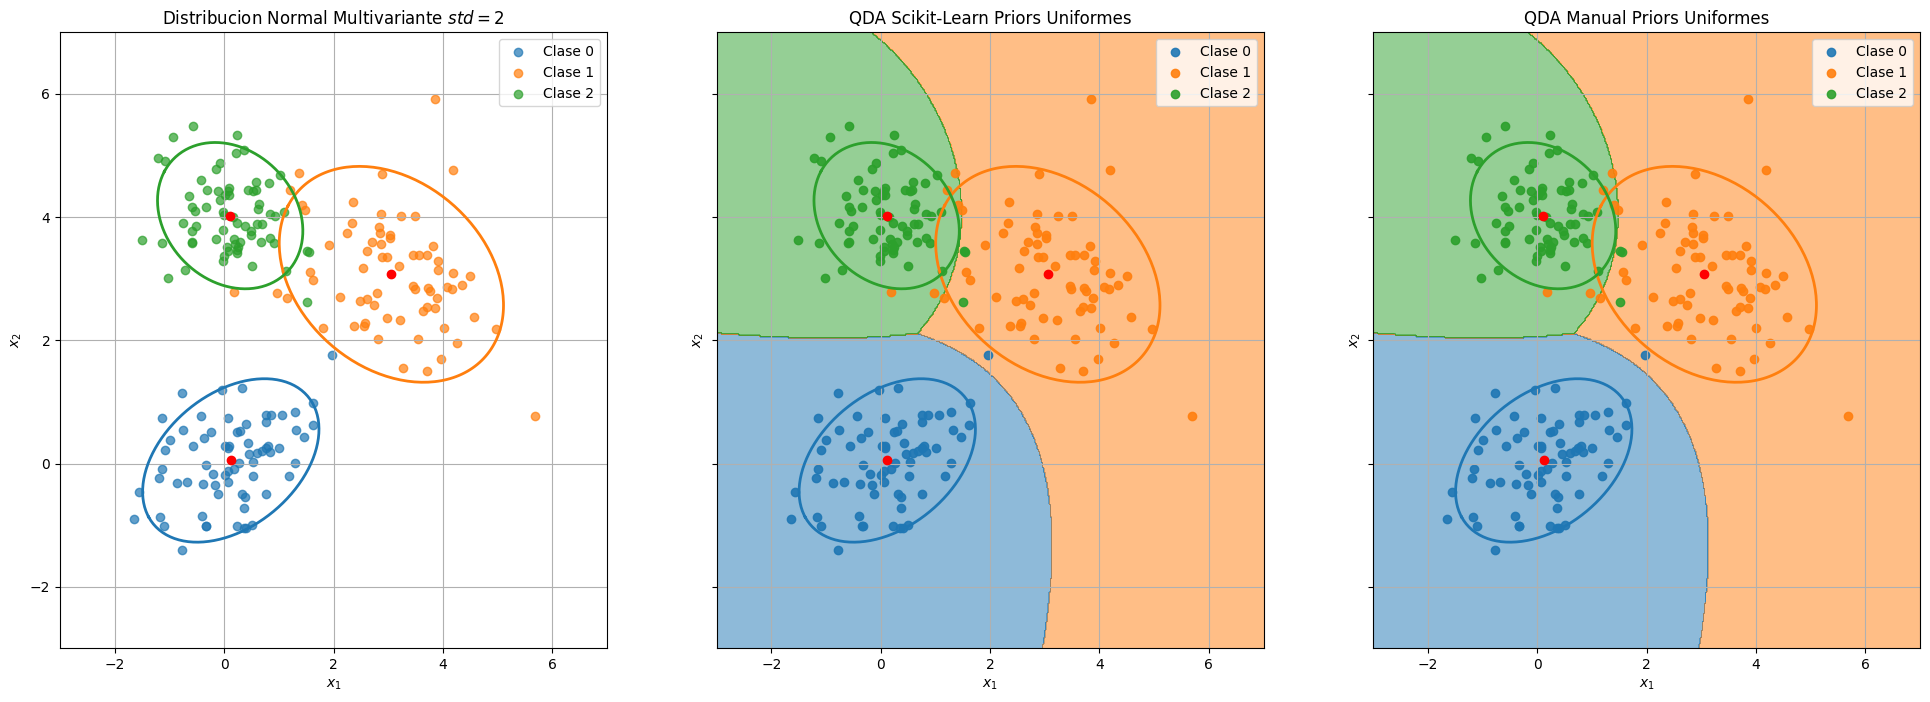

In [3]:
# Generamos los datos siguiendo una distribuccion normal multivariante

np.random.seed(42)

n_samples = [70, 70, 70] 

means = [[0, 0], [3, 3], [0, 4]]
covariances = [[[0.8, 0.3], [0.3, 0.5]], [[1.0, -0.2], [-0.2, 0.7]], [[0.5, 0.0], [0.0, 0.5]]]

def generate_data(means, covariances, n_samples):

    features = []
    labels = []

    for idx in range(0, len(means)):
        x = np.random.multivariate_normal(mean = means[idx], cov = covariances[idx], size = n_samples[idx])

        features.append(x)
        labels.append(np.full(shape = n_samples[idx], fill_value = idx))

    features = np.vstack(features)
    labels = np.concatenate(labels)

    return features, labels

features, labels = generate_data(means, covariances, n_samples)

# Estimamos la Media y la Matriz de Covarianza Proveniente de los Datos Generados (Para cada clase por separado)

estimated_means = []
estimated_covs = []

for c in range(len(means)):
    X_c = features[labels == c]

    mean = np.mean(X_c, axis = 0)
    cov = np.cov(X_c, rowvar = False)

    estimated_means.append(mean)
    estimated_covs.append(cov)

# Ajustamos el Discriminador Cuadratico de Sckit-Learn

qda = QuadraticDiscriminantAnalysis(reg_param = 0.0)

qda.fit(features, labels)

# Ajustamos el Discriminador Cuadratico Manual 

def discriminant(grid, means, covariances): 

    n = grid.shape[0] 
    D = grid.shape[1]

    predictions = np.zeros(shape = (n, len(means)))

    for classe in range(0, len(means)): 

        mean = means[classe] 
        cov = covariances[classe]     

        cov_sign, cov_log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)

        diff = grid - mean
        pred = ((1/2) * cov_log_det) + ((1/2) * np.einsum('ij,jk,ik->i', diff, cov_inv, diff))

        predictions[:, classe] = pred 

    predictions = np.argmin(predictions, axis = 1) 

    return predictions

# Definimos una Malla para Inferir todos los Puntos de ese espacio

x_vals = np.linspace(-3, 7, 500) 
y_vals = np.linspace(-3, 7, 500)

X, Y = np.meshgrid(x_vals, y_vals)

grid = np.c_[X.ravel(), Y.ravel()]

# Inferimos sobre la Malla con el Discriminador previamente ajustado

predict_auto = qda.predict(grid)
predict_auto = predict_auto.reshape(X.shape) 

predict_manual = discriminant(grid, estimated_means, estimated_covs)
predict_manual = predict_manual.reshape(X.shape) 

# Visualizamos

def plot_cov_ellipse(cov, mean, ax, std, color, **kwargs):
   
    eigvals, eigvecs = np.linalg.eigh(cov)

    order = eigvals.argsort()[::-1]

    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    theta = np.linspace(0, 2*np.pi, 200)
    circle = np.array([np.cos(theta), np.sin(theta)])

    scale = std * np.sqrt(eigvals)

    transform = eigvecs @ np.diag(scale)
    ellipse = transform @ circle + mean.reshape(2, 1)

    ax.plot(ellipse[0], ellipse[1], color = color, linewidth = 2)

colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 8), sharex = True, sharey = True)

for class_id in range(0, len(means)):
    X_class = features[labels == class_id]
    
    ax[0].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.7, color = colors[class_id])
    
    mean = np.mean(X_class, axis = 0)
    ax[0].plot(mean[0], mean[1], 'ro')
    
    cov = np.cov(X_class.T)
    plot_cov_ellipse(cov, mean, ax[0], std = 2, color = colors[class_id])

ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title(f"Distribucion Normal Multivariante $std = 2$")
ax[0].legend()
ax[0].grid(True)

ax[1].contourf(X, Y, predict_auto, alpha = 0.5, cmap = ListedColormap(colors))
ax[2].contourf(X, Y, predict_manual, alpha = 0.5, cmap = ListedColormap(colors))

for idx in range(1, 3):
    for class_id in range(0, len(means)):
        X_class = features[labels == class_id]
        
        ax[idx].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.9, color = colors[class_id])
        
        mean = np.mean(X_class, axis = 0)
        ax[idx].plot(mean[0], mean[1], 'ro')
        
        cov = np.cov(X_class.T)
        plot_cov_ellipse(cov, mean, ax[idx], std = 2, color = colors[class_id])

    ax[idx].set_xlabel("$x_1$")
    ax[idx].set_ylabel("$x_2$")
    ax[idx].legend()
    ax[idx].grid(True)

ax[1].set_title(f"QDA Scikit-Learn Priors Uniformes")
ax[2].set_title(f"QDA Manual Priors Uniformes")

plt.show()

# **Linear Discriminat Analysis (LDA)**

En **LDA** todas las clases $c$ tienen una **matriz de covarianza** $\Sigma$ **compartida**, lo que da lugar a **fronteras de decisión lineales** en el espacio de entrada.

La matriz de covarianza común $\Sigma$ se estima como una combinación ponderada de las matrices de covarianza intra-clase:

$$\Sigma = \frac{1}{N - c} \sum_{i=1}^{c} (n_i - 1) \Sigma_i$$

En donde: 

* $N$ es el número total de muestras

* $n_i$ es el número de muestras de la clase $i$

* $c$ es el número total de clases

### **Con Priors**

Cuando se **conocen** o **se estiman** las probabilidades a **priori** $p(y = c \mid \pi)$, la regla de decisión óptima es:

$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log p(y = c \mid \pi) + \log \mathcal{N}(x \mid \mu_c, \Sigma_c)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log p(y = c \mid \pi) + \log \left(\frac{1}{(2 \pi)^{\frac{D}{2}} \cdot |\Sigma_c|^{\frac{1}{2}}} \cdot e^{-\frac{1}{2} (x - \mu_c)^T \Sigma_c^{-1} (x - \mu_c)}\right)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log p(y = c \mid \pi) + \log \left(\frac{1}{(2 \pi)^{\frac{D}{2}} \cdot |\Sigma|^{\frac{1}{2}}} \cdot e^{-\frac{1}{2} (x - \mu_c)^T \Sigma^{-1} (x - \mu_c)}\right)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left(\log p(y = c \mid \pi) - \frac{D}{2} \log(2 \pi) - \frac{1}{2} \log(|\Sigma|) - \frac{1}{2} (x - \mu_c)^T \Sigma^{-1} (x - \mu_c)\right)$$

$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left[\log p(y = c \mid \pi) - \frac{1}{2}(x - \mu_c)^T \Sigma^{-1} (x - \mu_c)\right]$$

**Nota:** Se omiten los términos constantes respecto a $c$ en la función de decisión, ya que no afectan el resultado del operador $\argmax$

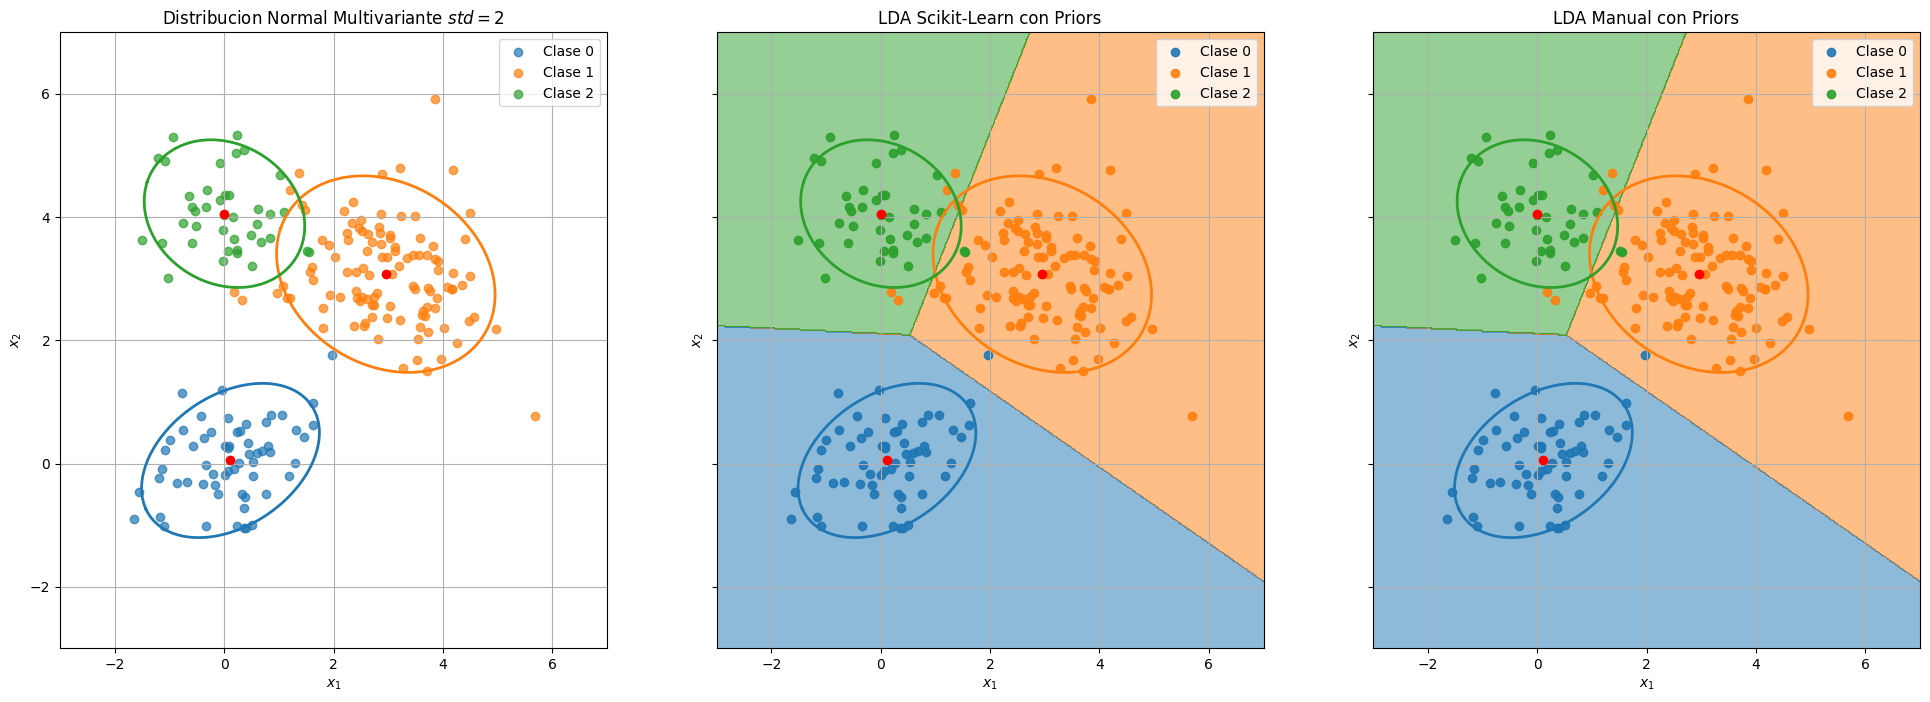

In [4]:
# Generamos los datos siguiendo una distribuccion normal multivariante

np.random.seed(42)

n_samples = [60, 110, 40] 

means = [[0, 0], [3, 3], [0, 4]]
covariances = [[[0.8, 0.3], [0.3, 0.5]], [[1.0, -0.2], [-0.2, 0.7]], [[0.5, 0.0], [0.0, 0.5]]]

def generate_data(means, covariances, n_samples):

    features = []
    labels = []

    for idx in range(0, len(means)):
        x = np.random.multivariate_normal(mean = means[idx], cov = covariances[idx], size = n_samples[idx])

        features.append(x)
        labels.append(np.full(shape = n_samples[idx], fill_value = idx))

    features = np.vstack(features)
    labels = np.concatenate(labels)

    return features, labels

features, labels = generate_data(means, covariances, n_samples)

# Calculamos la Distribucion Prior de las Clases 

priors = np.array(n_samples) / np.sum(n_samples)

# Estimamos la Media y la Matriz de Covarianza Proveniente de los Datos Generados (Estimamos una matriz de Covarianza Global ponderando cada clase)

estimated_means = []
estimated_covs = []

for c in range(len(means)):
    X_c = features[labels == c]

    mean = np.mean(X_c, axis = 0)
    cov = np.cov(X_c, rowvar = False)

    estimated_means.append(mean)
    estimated_covs.append(cov)

N = features.shape[0]
classes = len(estimated_means)

global_cov = np.zeros((features.shape[1], features.shape[1]))

for c in range(len(means)):
    X_c = features[labels == c]
    cov = estimated_covs[c] 

    n = X_c.shape[0] 

    global_cov += (n - 1) * cov

global_cov = (1 / (N - classes)) * global_cov

# Ajustamos el Discriminador Cuadratico de Sckit-Learn

lda = LinearDiscriminantAnalysis(priors = priors)

lda.fit(features, labels)

# Ajustamos el Discriminador Cuadratico Manual 

def discriminant(grid, priors, means, global_cov): 

    n = grid.shape[0] 
    D = grid.shape[1]
    cov_inv = np.linalg.inv(global_cov)

    predictions = np.zeros(shape = (n, len(means)))

    for classe in range(0, len(means)): 

        mean = means[classe]  
        prior = priors[classe]       

        diff = grid - mean
        pred = np.log(prior) - ((1/2) * np.einsum('ij,jk,ik->i', diff, cov_inv, diff))

        predictions[:, classe] = pred 

    predictions = np.argmax(predictions, axis = 1) 

    return predictions

# Definimos una Malla para Inferir todos los Puntos de ese espacio

x_vals = np.linspace(-3, 7, 500) 
y_vals = np.linspace(-3, 7, 500)

X, Y = np.meshgrid(x_vals, y_vals)

grid = np.c_[X.ravel(), Y.ravel()]

# Inferimos sobre la Malla con el Discriminador previamente ajustado

predict_auto = lda.predict(grid)
predict_auto = predict_auto.reshape(X.shape) 

predict_manual = discriminant(grid, priors, estimated_means, global_cov)
predict_manual = predict_manual.reshape(X.shape) 

# Visualizamos

def plot_cov_ellipse(cov, mean, ax, std, color, **kwargs):
   
    eigvals, eigvecs = np.linalg.eigh(cov)

    order = eigvals.argsort()[::-1]

    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    theta = np.linspace(0, 2*np.pi, 200)
    circle = np.array([np.cos(theta), np.sin(theta)])

    scale = std * np.sqrt(eigvals)

    transform = eigvecs @ np.diag(scale)
    ellipse = transform @ circle + mean.reshape(2, 1)

    ax.plot(ellipse[0], ellipse[1], color = color, linewidth = 2)

colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 8), sharex = True, sharey = True)

for class_id in range(0, len(means)):
    X_class = features[labels == class_id]
    
    ax[0].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.7, color = colors[class_id])
    
    mean = np.mean(X_class, axis = 0)
    ax[0].plot(mean[0], mean[1], 'ro')
    
    cov = np.cov(X_class.T)
    plot_cov_ellipse(cov, mean, ax[0], std = 2, color = colors[class_id])

ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title(f"Distribucion Normal Multivariante $std = 2$")
ax[0].legend()
ax[0].grid(True)

ax[1].contourf(X, Y, predict_auto, alpha = 0.5, cmap = ListedColormap(colors))
ax[2].contourf(X, Y, predict_manual, alpha = 0.5, cmap = ListedColormap(colors))

for idx in range(1, 3):
    for class_id in range(0, len(means)):
        X_class = features[labels == class_id]
        
        ax[idx].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.9, color = colors[class_id])
        
        mean = np.mean(X_class, axis = 0)
        ax[idx].plot(mean[0], mean[1], 'ro')
        
        cov = np.cov(X_class.T)
        plot_cov_ellipse(cov, mean, ax[idx], std = 2, color = colors[class_id])

    ax[idx].set_xlabel("$x_1$")
    ax[idx].set_ylabel("$x_2$")
    ax[idx].legend()
    ax[idx].grid(True)

ax[1].set_title(f"LDA Scikit-Learn con Priors")
ax[2].set_title(f"LDA Manual con Priors")

plt.show()

### **Con Priors Uniformes (o Desconocidos)**

Si se **desconoce** la **distribución a priori**, o se asume que **todas las clases son equiprobables**, entonces la regla de decisión se basa únicamente en el **máximo de verosimilitud**:

$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log \mathcal{N}(x \mid \mu_c, \Sigma_c)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log \left(\frac{1}{(2 \pi)^{\frac{D}{2}} \cdot |\Sigma_c|^{\frac{1}{2}}} \cdot e^{-\frac{1}{2} (x - \mu_c)^T \Sigma_c^{-1} (x - \mu_c)}\right)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \log \left(\frac{1}{(2 \pi)^{\frac{D}{2}} \cdot |\Sigma|^{\frac{1}{2}}} \cdot e^{-\frac{1}{2} (x - \mu_c)^T \Sigma^{-1} (x - \mu_c)}\right)$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left(- \frac{D}{2} \log(2 \pi) - \frac{1}{2} \log(|\Sigma|) - \frac{1}{2} (x - \mu_c)^T \Sigma^{-1} (x - \mu_c)\right)$$

$$\hat y(x) = \argmin_{c} \hspace{0.2cm} \left[\frac{1}{2} (x - \mu_c)^T \Sigma^{-1} (x - \mu_c)\right]$$

**Nota:** Se omiten los términos constantes respecto a $c$ en la función de decisión, ya que no afectan el resultado del operador $\argmax$

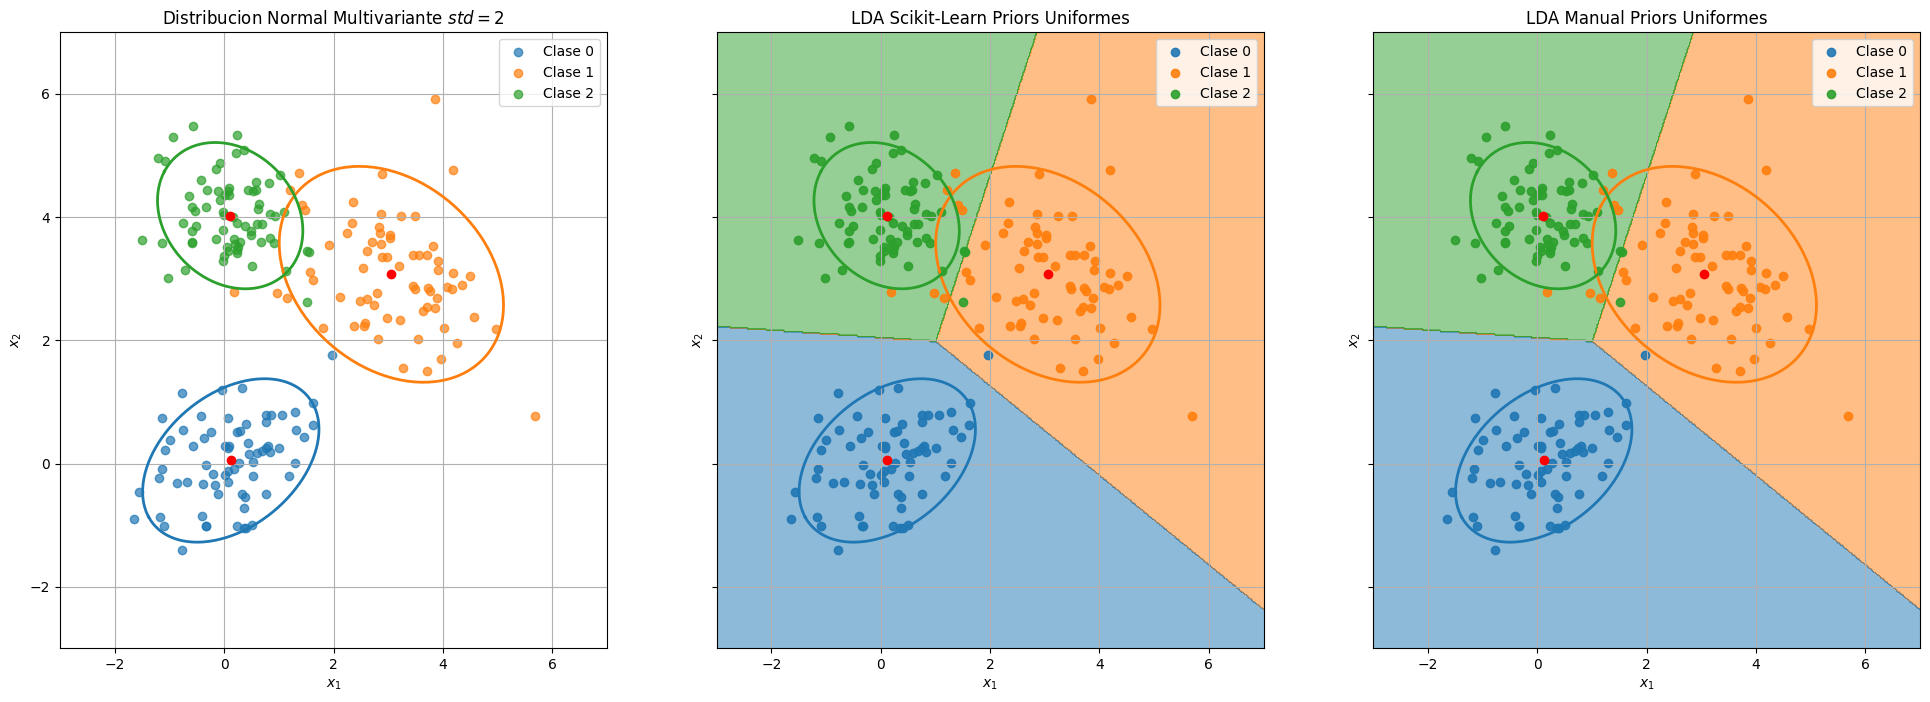

In [5]:
# Generamos los datos siguiendo una distribuccion normal multivariante

np.random.seed(42)

n_samples = [70, 70, 70] 

means = [[0, 0], [3, 3], [0, 4]]
covariances = [[[0.8, 0.3], [0.3, 0.5]], [[1.0, -0.2], [-0.2, 0.7]], [[0.5, 0.0], [0.0, 0.5]]]

def generate_data(means, covariances, n_samples):

    features = []
    labels = []

    for idx in range(0, len(means)):
        x = np.random.multivariate_normal(mean = means[idx], cov = covariances[idx], size = n_samples[idx])

        features.append(x)
        labels.append(np.full(shape = n_samples[idx], fill_value = idx))

    features = np.vstack(features)
    labels = np.concatenate(labels)

    return features, labels

features, labels = generate_data(means, covariances, n_samples)

# Estimamos la Media y la Matriz de Covarianza Proveniente de los Datos Generados (Estimamos una matriz de Covarianza Global ponderando cada clase)

estimated_means = []
estimated_covs = []

for c in range(len(means)):
    X_c = features[labels == c]

    mean = np.mean(X_c, axis = 0)
    cov = np.cov(X_c, rowvar = False)

    estimated_means.append(mean)
    estimated_covs.append(cov)

N = features.shape[0]
classes = len(estimated_means)

global_cov = np.zeros((features.shape[1], features.shape[1]))

for c in range(len(means)):
    X_c = features[labels == c]
    cov = estimated_covs[c] 

    n = X_c.shape[0] 

    global_cov += (n - 1) * cov

global_cov = (1 / (N - classes)) * global_cov

# Ajustamos el Discriminador Cuadratico de Sckit-Learn

lda = LinearDiscriminantAnalysis()

lda.fit(features, labels)

# Ajustamos el Discriminador Cuadratico Manual 

def discriminant(grid, means, global_cov): 

    n = grid.shape[0] 
    D = grid.shape[1]
    cov_inv = np.linalg.inv(global_cov)

    predictions = np.zeros(shape = (n, len(means)))

    for classe in range(0, len(means)): 

        mean = means[classe]        

        diff = grid - mean
        pred = ((1/2) * np.einsum('ij,jk,ik->i', diff, cov_inv, diff))

        predictions[:, classe] = pred 

    predictions = np.argmin(predictions, axis = 1) 

    return predictions

# Definimos una Malla para Inferir todos los Puntos de ese espacio

x_vals = np.linspace(-3, 7, 500) 
y_vals = np.linspace(-3, 7, 500)

X, Y = np.meshgrid(x_vals, y_vals)

grid = np.c_[X.ravel(), Y.ravel()]

# Inferimos sobre la Malla con el Discriminador previamente ajustado

predict_auto = lda.predict(grid)
predict_auto = predict_auto.reshape(X.shape) 

predict_manual = discriminant(grid, estimated_means, global_cov)
predict_manual = predict_manual.reshape(X.shape) 

# Visualizamos

def plot_cov_ellipse(cov, mean, ax, std, color, **kwargs):
   
    eigvals, eigvecs = np.linalg.eigh(cov)

    order = eigvals.argsort()[::-1]

    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    theta = np.linspace(0, 2*np.pi, 200)
    circle = np.array([np.cos(theta), np.sin(theta)])

    scale = std * np.sqrt(eigvals)

    transform = eigvecs @ np.diag(scale)
    ellipse = transform @ circle + mean.reshape(2, 1)

    ax.plot(ellipse[0], ellipse[1], color = color, linewidth = 2)

colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 8), sharex = True, sharey = True)

for class_id in range(0, len(means)):
    X_class = features[labels == class_id]
    
    ax[0].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.7, color = colors[class_id])
    
    mean = np.mean(X_class, axis = 0)
    ax[0].plot(mean[0], mean[1], 'ro')
    
    cov = np.cov(X_class.T)
    plot_cov_ellipse(cov, mean, ax[0], std = 2, color = colors[class_id])

ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title(f"Distribucion Normal Multivariante $std = 2$")
ax[0].legend()
ax[0].grid(True)

ax[1].contourf(X, Y, predict_auto, alpha = 0.5, cmap = ListedColormap(colors))
ax[2].contourf(X, Y, predict_manual, alpha = 0.5, cmap = ListedColormap(colors))

for idx in range(1, 3):
    for class_id in range(0, len(means)):
        X_class = features[labels == class_id]
        
        ax[idx].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.9, color = colors[class_id])
        
        mean = np.mean(X_class, axis = 0)
        ax[idx].plot(mean[0], mean[1], 'ro')
        
        cov = np.cov(X_class.T)
        plot_cov_ellipse(cov, mean, ax[idx], std = 2, color = colors[class_id])

    ax[idx].set_xlabel("$x_1$")
    ax[idx].set_ylabel("$x_2$")
    ax[idx].legend()
    ax[idx].grid(True)

ax[1].set_title(f"LDA Scikit-Learn Priors Uniformes")
ax[2].set_title(f"LDA Manual Priors Uniformes")

plt.show()

# **Transición de LDA Generativo a un Modelo Discriminativo con Softmax**

El modelo **Linear Discriminant Analysis** (LDA) predice la clase de una muestra $x$ mediante una regla de decisión basada en **discriminantes lineales**, lo que produce **predicciones deterministas** (etiquetas duras):

$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left[ \log p(y = c \mid \pi) - \frac{1}{2}(x - \mu_c)^T \Sigma^{-1} (x - \mu_c)\right]$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left[ \log p(y = c \mid \pi) - \frac{1}{2}\left(x^T\Sigma^{-1}x -  \mu_c^T\Sigma^{-1}x - x^T\Sigma^{-1}\mu_c + \mu_c^T\Sigma^{-1}\mu_c\right)\right]$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left[ \log p(y = c \mid \pi) + \frac{1}{2} \left(\mu_c^T\Sigma^{-1}x + x^T\Sigma^{-1}\mu_c - \mu_c^T\Sigma^{-1}\mu_c\right)\right]$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left[ \log p(y = c \mid \pi) + \frac{1}{2} \left(2\mu_c^T\Sigma^{-1}x - \mu_c^T\Sigma^{-1}\mu_c\right)\right]$$
$$\hat y(x) = \argmax_{c} \hspace{0.2cm} \left[ \log p(y = c \mid \pi) + \mu_c^T\Sigma^{-1}x - \frac{1}{2}\mu_c^T\Sigma^{-1}\mu_c\right]$$

Definimos el **discriminador** lineal para cada **clase** $c$:

$$g_c = \log p(y = c \mid \pi) + \mu_c^T\Sigma^{-1}x - \frac{1}{2}\mu_c^T\Sigma^{-1}\mu_c$$

Para obtener **predicciones probabilísticas** (etiquetas blandas), aplicamos la función **softmax** sobre los **discriminadores**:

$$p(y = c \mid x, \theta_c) = \frac{e^{g_c(x)}}{\sum_c e^{g_c(x)}}$$

$$p(y = c \mid x, \theta_c) = \frac{e^{\log p(y = c \mid \pi) + \mu_c^T\Sigma^{-1}x - \frac{1}{2}\mu_c^T\Sigma^{-1}\mu_c}}{\sum_c e^{\log p(y = c \mid \pi) + \mu_c^T\Sigma^{-1}x - \frac{1}{2}\mu_c^T\Sigma^{-1}\mu_c}}$$

Para simplificar, definimos:

$$\gamma_c = \log p(y = c \mid \pi) - \frac{1}{2}\mu_c^T\Sigma^{-1}\mu_c$$

$$\beta_c = \mu_c^T\Sigma^{-1}$$

Entonces:

$$p(y = c \mid x, \theta_c) = \frac{e^{\beta_c x + \gamma_c}}{\sum_c e^{\beta_c x + \gamma_c}}$$

**Nota:** El término $x^T \Sigma^{-1} x$ fue eliminado, ya que no depende de la clase $c$ y no afecta el resultado del $\argmax$ ni del softmax.


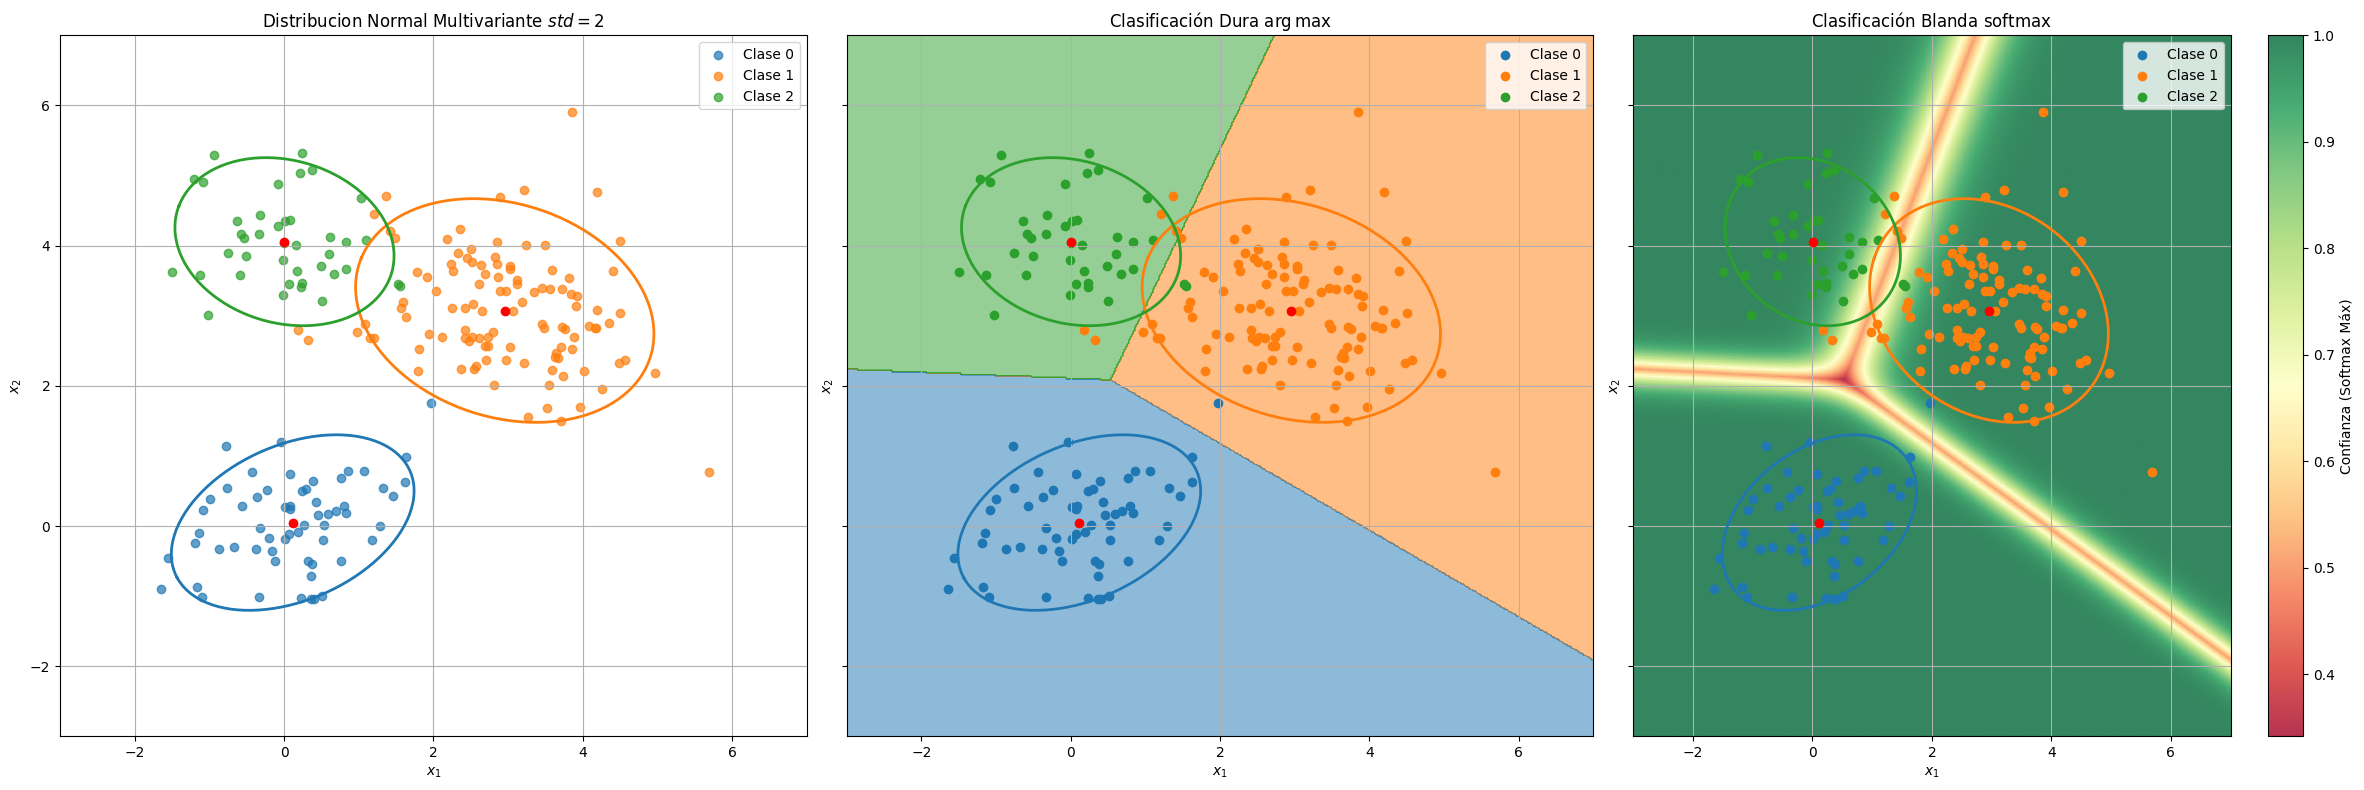

In [6]:
# Generamos los datos siguiendo una distribuccion normal multivariante

np.random.seed(42)

n_samples = [60, 110, 40] 

means = [[0, 0], [3, 3], [0, 4]]
covariances = [[[0.8, 0.3], [0.3, 0.5]], [[1.0, -0.2], [-0.2, 0.7]], [[0.5, 0.0], [0.0, 0.5]]]

def generate_data(means, covariances, n_samples):

    features = []
    labels = []

    for idx in range(0, len(means)):
        x = np.random.multivariate_normal(mean = means[idx], cov = covariances[idx], size = n_samples[idx])

        features.append(x)
        labels.append(np.full(shape = n_samples[idx], fill_value = idx))

    features = np.vstack(features)
    labels = np.concatenate(labels)

    return features, labels

features, labels = generate_data(means, covariances, n_samples)

# Calculamos la Distribucion Prior de las Clases 

priors = np.array(n_samples) / np.sum(n_samples)

# Estimamos la Media y la Matriz de Covarianza Proveniente de los Datos Generados (Estimamos una matriz de Covarianza Global ponderando cada clase)

estimated_means = []
estimated_covs = []

for c in range(len(means)):
    X_c = features[labels == c]

    mean = np.mean(X_c, axis = 0)
    cov = np.cov(X_c, rowvar = False)

    estimated_means.append(mean)
    estimated_covs.append(cov)

N = features.shape[0]
classes = len(estimated_means)

global_cov = np.zeros((features.shape[1], features.shape[1]))

for c in range(len(means)):
    X_c = features[labels == c]
    cov = estimated_covs[c] 

    n = X_c.shape[0] 

    global_cov += (n - 1) * cov

global_cov = (1 / (N - classes)) * global_cov

# Ajustamos el Discriminador Cuadratico de Sckit-Learn

lda = LinearDiscriminantAnalysis(priors = priors)

lda.fit(features, labels)

# Ajustamos el Discriminador Cuadratico Manual 

def discriminant(grid, priors, means, global_cov): 

    n = grid.shape[0] 
    D = grid.shape[1]
    cov_inv = np.linalg.inv(global_cov)

    predictions = np.zeros(shape = (n, len(means)))

    for classe in range(0, len(means)): 

        mean = means[classe]  
        prior = priors[classe]       

        diff = grid - mean
        pred = np.log(prior) - ((1/2) * np.einsum('ij,jk,ik->i', diff, cov_inv, diff))

        predictions[:, classe] = pred 

    return predictions

# Definimos una Malla para Inferir todos los Puntos de ese espacio

x_vals = np.linspace(-3, 7, 500) 
y_vals = np.linspace(-3, 7, 500)

X, Y = np.meshgrid(x_vals, y_vals)

grid = np.c_[X.ravel(), Y.ravel()]

# Definimos la Funcion Softmax 

def softmax(logits): 

    ### Artificio para estabilidad numerica 
    logits = logits - np.max(logits, axis = 1, keepdims = True) 

    exp_logits = np.exp(logits) 

    z = exp_logits / np.sum(exp_logits, axis = 1, keepdims = True)

    return z

# Inferimos sobre la Malla con el Discriminador previamente ajustado

logits = discriminant(grid, priors, estimated_means, global_cov)

hard_preds = np.argmax(logits, axis = 1) 
soft_preds = softmax(logits)

hard_class_map = hard_preds.reshape(X.shape)
soft_class_map = soft_preds.reshape(X.shape[0], X.shape[1], -1)

max_prob = np.max(soft_preds, axis = 1).reshape(X.shape)

# Visualizamos

def plot_cov_ellipse(cov, mean, ax, std, color, **kwargs):
   
    eigvals, eigvecs = np.linalg.eigh(cov)

    order = eigvals.argsort()[::-1]

    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    theta = np.linspace(0, 2*np.pi, 200)
    circle = np.array([np.cos(theta), np.sin(theta)])

    scale = std * np.sqrt(eigvals)

    transform = eigvecs @ np.diag(scale)
    ellipse = transform @ circle + mean.reshape(2, 1)

    ax.plot(ellipse[0], ellipse[1], color = color, linewidth = 2)

colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 8), sharex = True, sharey = True)

for class_id in range(0, len(means)):
    X_class = features[labels == class_id]
    
    ax[0].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.7, color = colors[class_id])
    
    mean = np.mean(X_class, axis = 0)
    ax[0].plot(mean[0], mean[1], 'ro')
    
    cov = np.cov(X_class.T)
    plot_cov_ellipse(cov, mean, ax[0], std = 2, color = colors[class_id])

ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title(f"Distribucion Normal Multivariante $std = 2$")
ax[0].legend()
ax[0].grid(True)

ax[1].contourf(X, Y, hard_class_map, alpha = 0.5, cmap = ListedColormap(colors))

cmap_prob = plt.cm.RdYlGn
prob_plot = ax[2].imshow(max_prob, origin = "lower", extent = [-3, 7, -3, 7], cmap = cmap_prob, alpha = 0.8, aspect = 'auto')
fig.colorbar(prob_plot, ax = ax[2], label = "Confianza (Softmax Máx)")

for idx in range(1, 3):
    for class_id in range(0, len(means)):
        X_class = features[labels == class_id]
        
        ax[idx].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', color = colors[class_id])
        
        mean = np.mean(X_class, axis = 0)
        ax[idx].plot(mean[0], mean[1], 'ro')
        
        cov = np.cov(X_class.T)
        plot_cov_ellipse(cov, mean, ax[idx], std = 2, color = colors[class_id])

    ax[idx].set_xlabel("$x_1$")
    ax[idx].set_ylabel("$x_2$")
    ax[idx].legend()
    ax[idx].grid(True)

ax[1].set_title(r"Clasificación Dura $\arg\max$")
ax[2].set_title(r"Clasificación Blanda $\text{softmax}$")

plt.tight_layout()
plt.show()

# **Temperatura en la función Softmax**

La función softmax puede ajustarse mediante un parámetro de temperatura $T > 0$, que controla la confianza del modelo en sus predicciones.

Dado un discriminante lineal $g_c(x)$:

$$g_c = \log p(y = c \mid \pi) + \mu_c^T\Sigma^{-1}x - \frac{1}{2}\mu_c^T\Sigma^{-1}\mu_c$$

Aplicamos la version de softmax con temperatura $T$

$$p(y = c \mid x, \theta_c, T) = \frac{e^{\frac{g_c(x)}{T}}}{\sum_c e^{\frac{g_c(x)}{T}}}$$

* Cuando $T \to 0$, la softmax se comporta como una función $\arg\max$, es decir, asigna casi toda la probabilidad a la clase con mayor $g_c(x)$.

* Cuando $T \to \infty$, la distribución se aplana, y todas las clases tienden a tener probabilidades similares, sin importar los valores de $g_c(x)$.

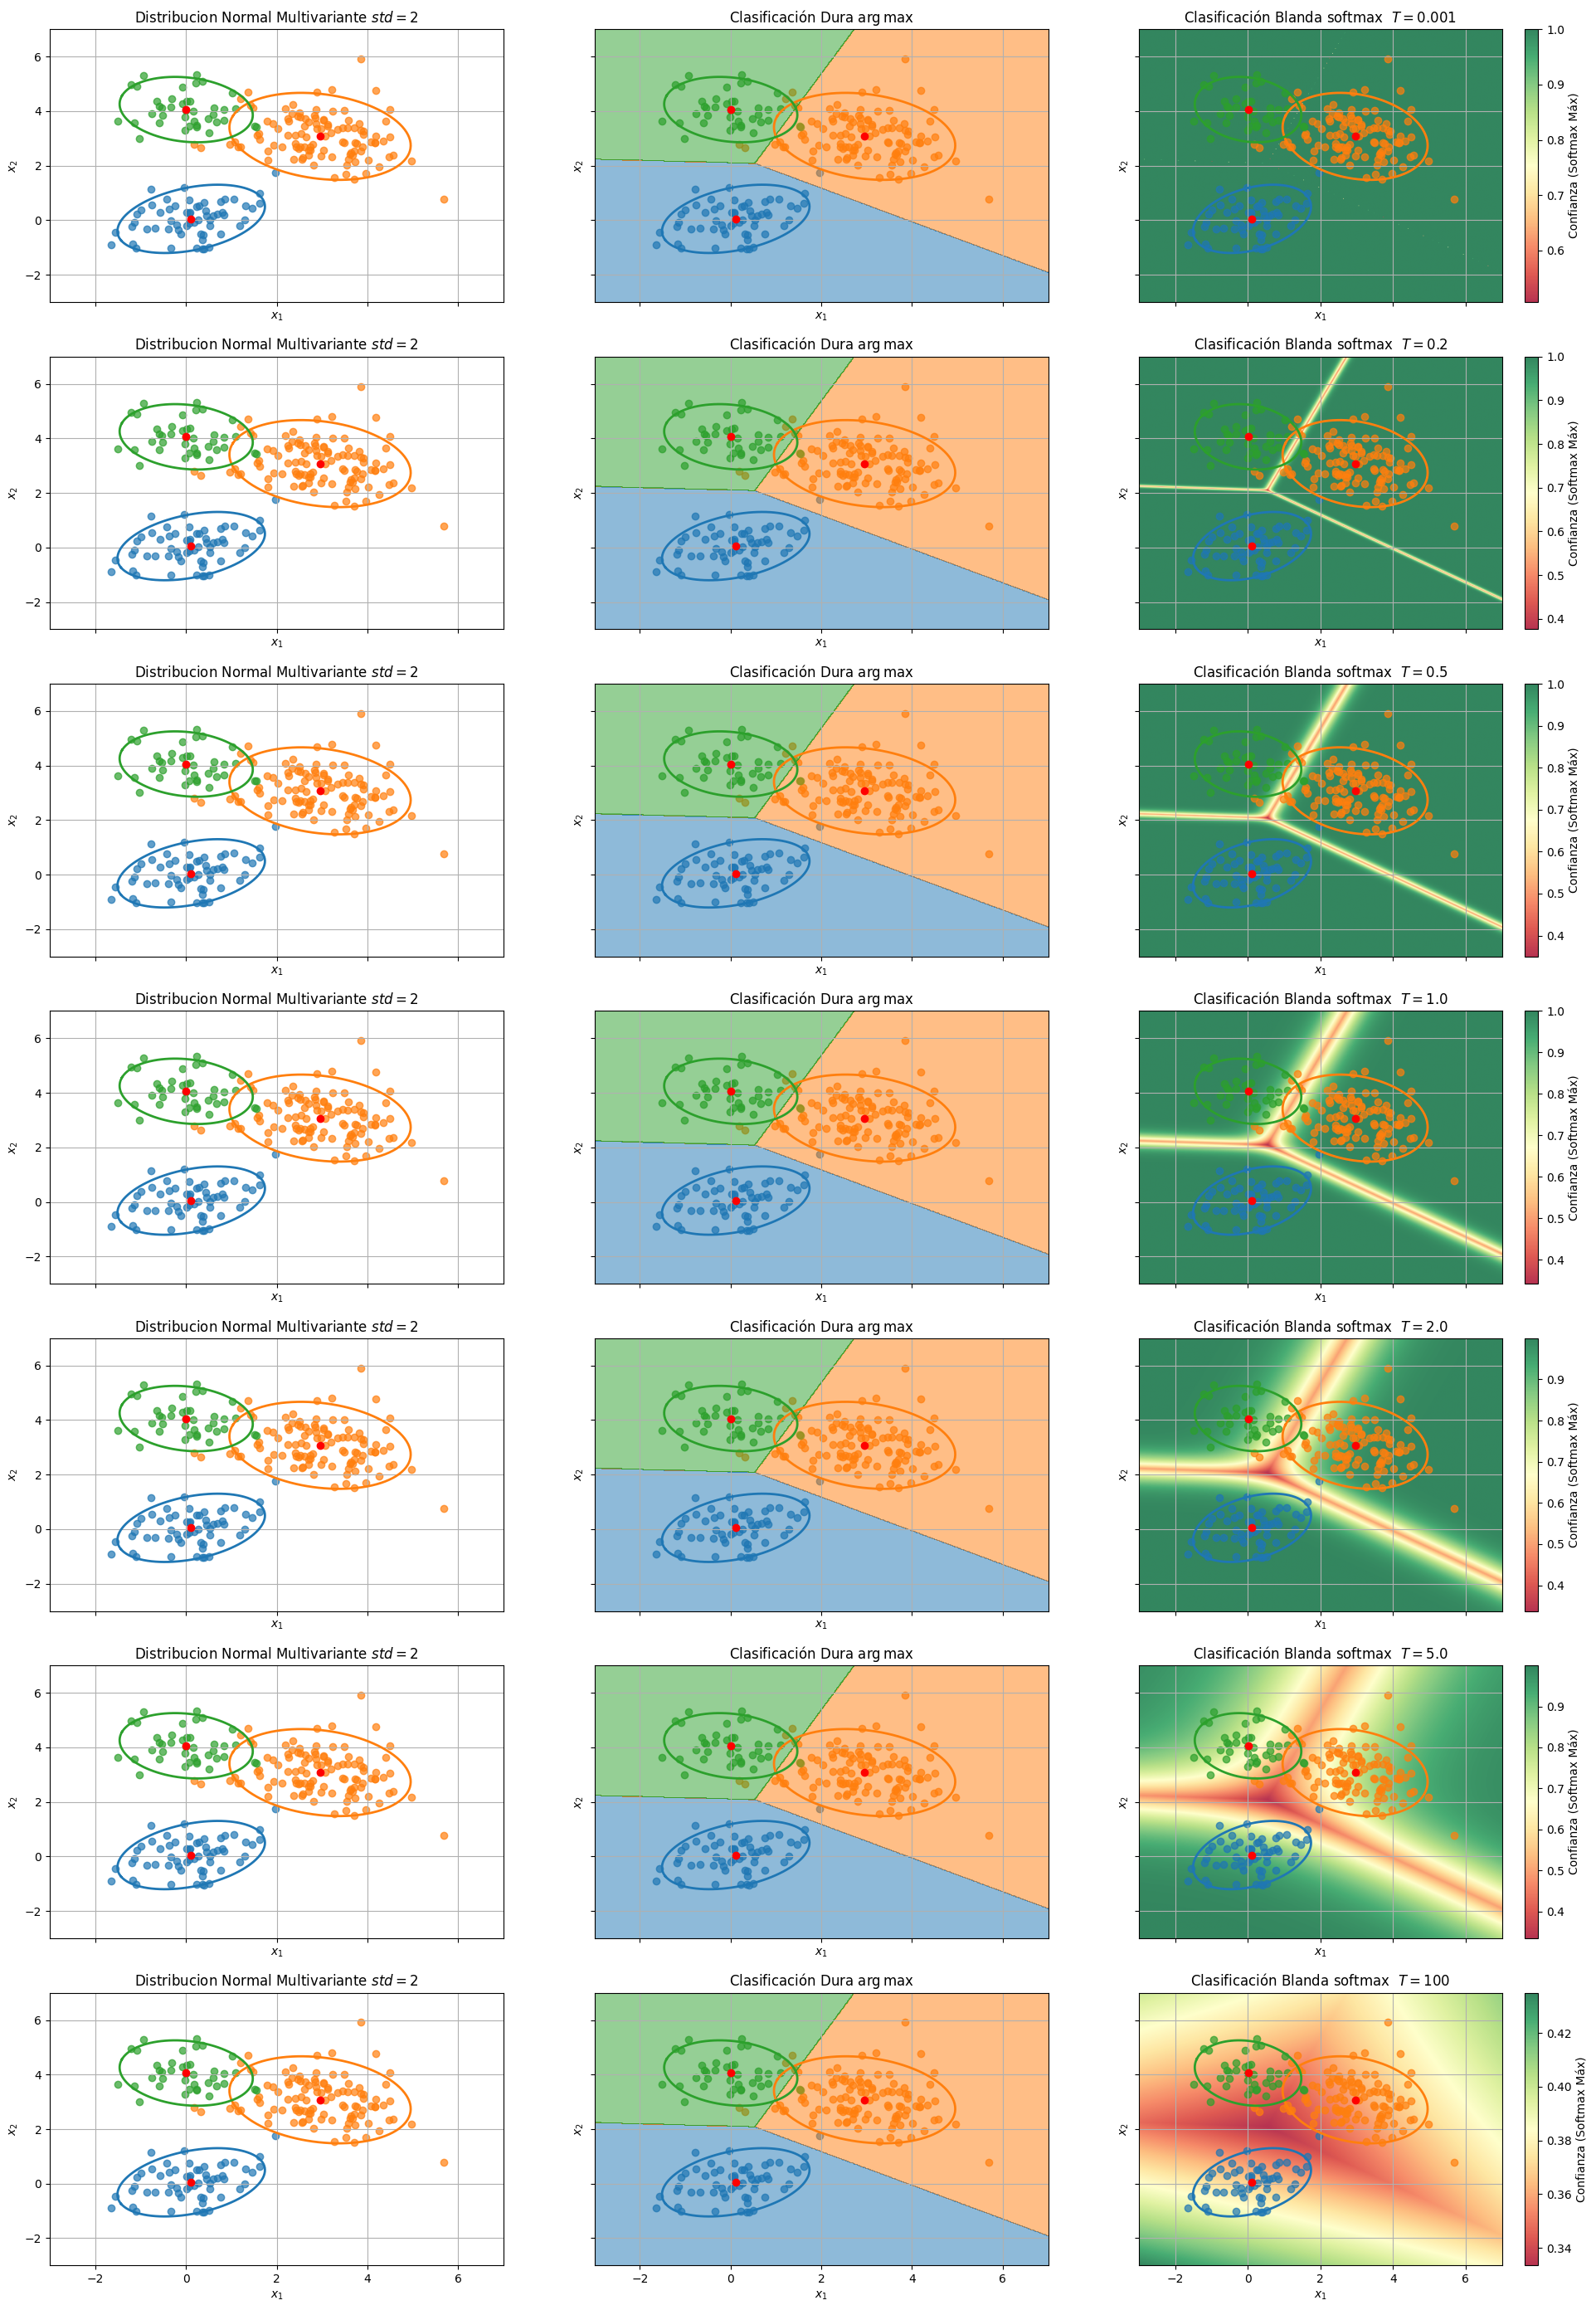

In [7]:
# Generamos los datos siguiendo una distribuccion normal multivariante

np.random.seed(42)

n_samples = [60, 110, 40] 

means = [[0, 0], [3, 3], [0, 4]]
covariances = [[[0.8, 0.3], [0.3, 0.5]], [[1.0, -0.2], [-0.2, 0.7]], [[0.5, 0.0], [0.0, 0.5]]]

def generate_data(means, covariances, n_samples):

    features = []
    labels = []

    for idx in range(0, len(means)):
        x = np.random.multivariate_normal(mean = means[idx], cov = covariances[idx], size = n_samples[idx])

        features.append(x)
        labels.append(np.full(shape = n_samples[idx], fill_value = idx))

    features = np.vstack(features)
    labels = np.concatenate(labels)

    return features, labels

features, labels = generate_data(means, covariances, n_samples)

# Calculamos la Distribucion Prior de las Clases 

priors = np.array(n_samples) / np.sum(n_samples)

# Estimamos la Media y la Matriz de Covarianza Proveniente de los Datos Generados (Estimamos una matriz de Covarianza Global ponderando cada clase)

estimated_means = []
estimated_covs = []

for c in range(len(means)):
    X_c = features[labels == c]

    mean = np.mean(X_c, axis = 0)
    cov = np.cov(X_c, rowvar = False)

    estimated_means.append(mean)
    estimated_covs.append(cov)

N = features.shape[0]
classes = len(estimated_means)

global_cov = np.zeros((features.shape[1], features.shape[1]))

for c in range(len(means)):
    X_c = features[labels == c]
    cov = estimated_covs[c] 

    n = X_c.shape[0] 

    global_cov += (n - 1) * cov

global_cov = (1 / (N - classes)) * global_cov

# Ajustamos el Discriminador Cuadratico de Sckit-Learn

lda = LinearDiscriminantAnalysis(priors = priors)

lda.fit(features, labels)

# Ajustamos el Discriminador Cuadratico Manual 

def discriminant(grid, priors, means, global_cov): 

    n = grid.shape[0] 
    D = grid.shape[1]
    cov_inv = np.linalg.inv(global_cov)

    predictions = np.zeros(shape = (n, len(means)))

    for classe in range(0, len(means)): 

        mean = means[classe]  
        prior = priors[classe]       

        diff = grid - mean
        pred = np.log(prior) - ((1/2) * np.einsum('ij,jk,ik->i', diff, cov_inv, diff))

        predictions[:, classe] = pred 

    return predictions

# Definimos una Malla para Inferir todos los Puntos de ese espacio

x_vals = np.linspace(-3, 7, 500) 
y_vals = np.linspace(-3, 7, 500)

X, Y = np.meshgrid(x_vals, y_vals)

grid = np.c_[X.ravel(), Y.ravel()]

# Definimos la Funcion Softmax 

temperaturas = [0.001, 0.2, 0.5, 1.0, 2.0, 5.0, 100]

def softmax(logits, T): 

    logits = logits / T

    ### Artificio para estabilidad numerica 
    logits = logits - np.max(logits, axis = 1, keepdims = True) 

    exp_logits = np.exp(logits) 

    z = exp_logits / np.sum(exp_logits, axis = 1, keepdims = True)

    return z

# Visualizamos

def plot_cov_ellipse(cov, mean, ax, std, color, **kwargs):
   
    eigvals, eigvecs = np.linalg.eigh(cov)

    order = eigvals.argsort()[::-1]

    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    theta = np.linspace(0, 2*np.pi, 200)
    circle = np.array([np.cos(theta), np.sin(theta)])

    scale = std * np.sqrt(eigvals)

    transform = eigvecs @ np.diag(scale)
    ellipse = transform @ circle + mean.reshape(2, 1)

    ax.plot(ellipse[0], ellipse[1], color = color, linewidth = 2)

colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(nrows=len(temperaturas), ncols=3, figsize=(24, 5 * len(temperaturas)), sharex=True, sharey=True)

for i, T in enumerate(temperaturas):

    logits = discriminant(grid, priors, estimated_means, global_cov)

    hard_preds = np.argmax(logits, axis = 1) 
    soft_preds = softmax(logits, T = T)

    hard_class_map = hard_preds.reshape(X.shape)
    soft_class_map = soft_preds.reshape(X.shape[0], X.shape[1], -1)

    max_prob = np.max(soft_preds, axis = 1).reshape(X.shape)

    for class_id in range(0, len(means)):
        X_class = features[labels == class_id]
        
        ax[i, 0].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.7, color = colors[class_id])
        ax[i, 1].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.7, color = colors[class_id])
        ax[i, 2].scatter(X_class[:, 0], X_class[:, 1], label = f'Clase {class_id}', alpha = 0.7, color = colors[class_id])
        
        mean = np.mean(X_class, axis = 0)
        ax[i, 0].plot(mean[0], mean[1], 'ro')
        ax[i, 1].plot(mean[0], mean[1], 'ro')
        ax[i, 2].plot(mean[0], mean[1], 'ro')
        
        cov = np.cov(X_class.T)
        plot_cov_ellipse(cov, mean, ax[i, 0], std = 2, color = colors[class_id])
        plot_cov_ellipse(cov, mean, ax[i, 1], std = 2, color = colors[class_id])
        plot_cov_ellipse(cov, mean, ax[i, 2], std = 2, color = colors[class_id])


    ax[i, 1].contourf(X, Y, hard_class_map, alpha = 0.5, cmap = ListedColormap(colors))

    cmap_prob = plt.cm.RdYlGn
    prob_plot = ax[i, 2].imshow(max_prob, origin = "lower", extent = [-3, 7, -3, 7], cmap = cmap_prob, alpha = 0.8, aspect = 'auto')
    fig.colorbar(prob_plot, ax = ax[i, 2], label = "Confianza (Softmax Máx)")

    for j in range(3):
        ax[i, j].set_ylabel("$x_2$")
        ax[i, j].set_xlabel("$x_1$")
        ax[i, j].set_xlim(-3, 7)
        ax[i, j].set_ylim(-3, 7)
        ax[i, j].grid(True)

    ax[i, 0].set_title(f"Distribucion Normal Multivariante $std = 2$")
    ax[i, 1].set_title(r"Clasificación Dura $\arg\max$")
    ax[i, 2].set_title(rf"Clasificación Blanda $\text{{softmax}}$  $T = {T}$")

plt.show()